### LSTM

In [4]:
#import
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### setup device

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Making data ready

In [6]:
data = pd.read_csv("./data_saved/EURUSD_M1_2020.csv")

print(data.head(10))
print(data.describe())

# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()

# data_norm.head(10)

             timestamp     open     high      low    close
0  2020-01-01 17:01:00  1.12106  1.12135  1.12106  1.12106
1  2020-01-01 17:02:00  1.12136  1.12139  1.12136  1.12136
2  2020-01-01 17:03:00  1.12135  1.12135  1.12120  1.12120
3  2020-01-01 17:04:00  1.12122  1.12125  1.12122  1.12122
4  2020-01-01 17:05:00  1.12125  1.12127  1.12125  1.12125
5  2020-01-01 17:06:00  1.12127  1.12127  1.12127  1.12127
6  2020-01-01 17:07:00  1.12127  1.12127  1.12127  1.12127
7  2020-01-01 17:08:00  1.12127  1.12127  1.12127  1.12127
8  2020-01-01 17:09:00  1.12127  1.12127  1.12127  1.12127
9  2020-01-01 17:10:00  1.12127  1.12127  1.12123  1.12123
                open           high            low          close
count  372334.000000  372334.000000  372334.000000  372334.000000
mean        1.141451       1.141539       1.141364       1.141364
std         0.044322       0.044318       0.044326       0.044326
min         1.063810       1.064010       1.063570       1.063570
25%         1.100260 

### move data to tensor gpu

In [8]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

data_tensor

tensor([[[1.1211],
         [1.1214],
         [1.1212],
         ...,
         [1.2216],
         [1.2215],
         [1.2214]]], device='cuda:0')

### LSTM in every 100 bars

In [9]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out

### Train Modals

In [10]:
# Parameters
input_size = 1  # Number of features (open, high, low, close)
hidden_size = 32  # Number of LSTM units
num_layers = 5  # Number of LSTM layers
output_size = 1  # Number of output classes (same as input size for reconstruction)

# Instantiate the model and move to GPU
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
forecast_interval = 1
losses = []
for epoch in tqdm(range(num_epochs)):
    # Forward pass
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)  # MSE loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    # Probabilistic forecasting every forecast_interval timestamps
    if (epoch+1) % forecast_interval == 0:
        with torch.no_grad():
            # Generate probabilistic forecasts for the next timestamp
            # You can adjust this part to implement your desired forecasting method
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

            # # Visualize the loss over epochs
            # plt.plot(losses)
            # plt.xlabel('Epoch')
            # plt.ylabel('Loss')
            # plt.title('Training Loss over Epochs')
            # plt.show()

            forecast_input = data_tensor[:, -1:, :]  # Use the last timestamp as input
            forecast_output = model(forecast_input)
            print(forecast_input)
            print(forecast_output)
            
            # Append the forecasted values to the data tensor
            data_tensor = torch.cat([data_tensor, forecast_output.unsqueeze(1)], dim=1)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372334, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:03<05:34,  3.38s/it]

Epoch [1/100], Loss: 1.6014
tensor([[[1.2214]]], device='cuda:0')
tensor([[-0.1245]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372335, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 2/100 [00:06<05:17,  3.24s/it]

Epoch [2/100], Loss: 1.5563
tensor([[[-0.1245]]], device='cuda:0')
tensor([[-0.1203]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372336, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|▎         | 3/100 [00:09<05:12,  3.22s/it]

Epoch [3/100], Loss: 1.5120
tensor([[[-0.1203]]], device='cuda:0')
tensor([[-0.1161]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372337, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  4%|▍         | 4/100 [00:12<05:05,  3.18s/it]

Epoch [4/100], Loss: 1.4680
tensor([[[-0.1161]]], device='cuda:0')
tensor([[-0.1118]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372338, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  5%|▌         | 5/100 [00:15<05:00,  3.16s/it]

Epoch [5/100], Loss: 1.4237
tensor([[[-0.1118]]], device='cuda:0')
tensor([[-0.1076]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372339, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  6%|▌         | 6/100 [00:19<04:56,  3.15s/it]

Epoch [6/100], Loss: 1.3786
tensor([[[-0.1076]]], device='cuda:0')
tensor([[-0.1033]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372340, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  7%|▋         | 7/100 [00:22<04:53,  3.15s/it]

Epoch [7/100], Loss: 1.3320
tensor([[[-0.1033]]], device='cuda:0')
tensor([[-0.0990]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372341, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  8%|▊         | 8/100 [00:25<04:50,  3.16s/it]

Epoch [8/100], Loss: 1.2832
tensor([[[-0.0990]]], device='cuda:0')
tensor([[-0.0947]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372342, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 9/100 [00:28<04:46,  3.15s/it]

Epoch [9/100], Loss: 1.2316
tensor([[[-0.0947]]], device='cuda:0')
tensor([[-0.0903]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372343, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 10/100 [00:31<04:42,  3.14s/it]

Epoch [10/100], Loss: 1.1763
tensor([[[-0.0903]]], device='cuda:0')
tensor([[-0.0859]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372344, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 11%|█         | 11/100 [00:34<04:39,  3.14s/it]

Epoch [11/100], Loss: 1.1165
tensor([[[-0.0859]]], device='cuda:0')
tensor([[-0.0814]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372345, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 12%|█▏        | 12/100 [00:37<04:37,  3.15s/it]

Epoch [12/100], Loss: 1.0513
tensor([[[-0.0814]]], device='cuda:0')
tensor([[-0.0769]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372346, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 13%|█▎        | 13/100 [00:41<04:37,  3.19s/it]

Epoch [13/100], Loss: 0.9799
tensor([[[-0.0769]]], device='cuda:0')
tensor([[-0.0724]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372347, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 14%|█▍        | 14/100 [00:44<04:34,  3.19s/it]

Epoch [14/100], Loss: 0.9011
tensor([[[-0.0724]]], device='cuda:0')
tensor([[-0.0677]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372348, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 15%|█▌        | 15/100 [00:47<04:33,  3.22s/it]

Epoch [15/100], Loss: 0.8142
tensor([[[-0.0677]]], device='cuda:0')
tensor([[-0.0630]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372349, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 16%|█▌        | 16/100 [00:51<04:33,  3.26s/it]

Epoch [16/100], Loss: 0.7184
tensor([[[-0.0630]]], device='cuda:0')
tensor([[-0.0582]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372350, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 17%|█▋        | 17/100 [00:54<04:31,  3.27s/it]

Epoch [17/100], Loss: 0.6137
tensor([[[-0.0582]]], device='cuda:0')
tensor([[-0.0534]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372351, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 18%|█▊        | 18/100 [00:57<04:33,  3.33s/it]

Epoch [18/100], Loss: 0.5014
tensor([[[-0.0534]]], device='cuda:0')
tensor([[-0.0485]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372352, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 19%|█▉        | 19/100 [01:01<04:30,  3.35s/it]

Epoch [19/100], Loss: 0.3850
tensor([[[-0.0485]]], device='cuda:0')
tensor([[-0.0436]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372353, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 20%|██        | 20/100 [01:04<04:30,  3.38s/it]

Epoch [20/100], Loss: 0.2708
tensor([[[-0.0436]]], device='cuda:0')
tensor([[-0.0387]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372354, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 21%|██        | 21/100 [01:08<04:30,  3.42s/it]

Epoch [21/100], Loss: 0.1680
tensor([[[-0.0387]]], device='cuda:0')
tensor([[-0.0338]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372355, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 22%|██▏       | 22/100 [01:11<04:34,  3.52s/it]

Epoch [22/100], Loss: 0.0864
tensor([[[-0.0338]]], device='cuda:0')
tensor([[-0.0291]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372356, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 23%|██▎       | 23/100 [01:15<04:36,  3.59s/it]

Epoch [23/100], Loss: 0.0323
tensor([[[-0.0291]]], device='cuda:0')
tensor([[-0.0244]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372357, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 24%|██▍       | 24/100 [01:19<04:38,  3.66s/it]

Epoch [24/100], Loss: 0.0062
tensor([[[-0.0244]]], device='cuda:0')
tensor([[-0.0200]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372358, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 25%|██▌       | 25/100 [01:23<04:34,  3.66s/it]

Epoch [25/100], Loss: 0.0033
tensor([[[-0.0200]]], device='cuda:0')
tensor([[-0.0159]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372359, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 26%|██▌       | 26/100 [01:26<04:27,  3.61s/it]

Epoch [26/100], Loss: 0.0163
tensor([[[-0.0159]]], device='cuda:0')
tensor([[-0.0122]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372360, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 27%|██▋       | 27/100 [01:30<04:30,  3.70s/it]

Epoch [27/100], Loss: 0.0355
tensor([[[-0.0122]]], device='cuda:0')
tensor([[-0.0090]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372361, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 28%|██▊       | 28/100 [01:34<04:27,  3.71s/it]

Epoch [28/100], Loss: 0.0518
tensor([[[-0.0090]]], device='cuda:0')
tensor([[-0.0062]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372362, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 29%|██▉       | 29/100 [01:38<04:23,  3.71s/it]

Epoch [29/100], Loss: 0.0605
tensor([[[-0.0062]]], device='cuda:0')
tensor([[-0.0039]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372363, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 30%|███       | 30/100 [01:41<04:19,  3.71s/it]

Epoch [30/100], Loss: 0.0615
tensor([[[-0.0039]]], device='cuda:0')
tensor([[-0.0020]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372364, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 31%|███       | 31/100 [01:45<04:14,  3.69s/it]

Epoch [31/100], Loss: 0.0566
tensor([[[-0.0020]]], device='cuda:0')
tensor([[-0.0005]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372365, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 32%|███▏      | 32/100 [01:49<04:11,  3.70s/it]

Epoch [32/100], Loss: 0.0480
tensor([[[-0.0005]]], device='cuda:0')
tensor([[0.0007]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372366, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 33%|███▎      | 33/100 [01:52<04:03,  3.64s/it]

Epoch [33/100], Loss: 0.0379
tensor([[[0.0007]]], device='cuda:0')
tensor([[0.0017]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372367, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 34%|███▍      | 34/100 [01:56<03:58,  3.61s/it]

Epoch [34/100], Loss: 0.0279
tensor([[[0.0017]]], device='cuda:0')
tensor([[0.0024]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372368, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 35%|███▌      | 35/100 [01:59<03:53,  3.59s/it]

Epoch [35/100], Loss: 0.0191
tensor([[[0.0024]]], device='cuda:0')
tensor([[0.0030]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372369, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 36%|███▌      | 36/100 [02:03<03:48,  3.56s/it]

Epoch [36/100], Loss: 0.0120
tensor([[[0.0030]]], device='cuda:0')
tensor([[0.0034]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372370, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 37%|███▋      | 37/100 [02:06<03:43,  3.55s/it]

Epoch [37/100], Loss: 0.0069
tensor([[[0.0034]]], device='cuda:0')
tensor([[0.0037]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372371, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 38%|███▊      | 38/100 [02:10<03:39,  3.54s/it]

Epoch [38/100], Loss: 0.0038
tensor([[[0.0037]]], device='cuda:0')
tensor([[0.0040]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372372, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 39%|███▉      | 39/100 [02:13<03:37,  3.57s/it]

Epoch [39/100], Loss: 0.0023
tensor([[[0.0040]]], device='cuda:0')
tensor([[0.0042]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372373, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 40%|████      | 40/100 [02:17<03:32,  3.54s/it]

Epoch [40/100], Loss: 0.0022
tensor([[[0.0042]]], device='cuda:0')
tensor([[0.0044]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372374, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 41%|████      | 41/100 [02:20<03:29,  3.54s/it]

Epoch [41/100], Loss: 0.0031
tensor([[[0.0044]]], device='cuda:0')
tensor([[0.0046]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372375, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 42%|████▏     | 42/100 [02:24<03:24,  3.52s/it]

Epoch [42/100], Loss: 0.0044
tensor([[[0.0046]]], device='cuda:0')
tensor([[0.0048]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372376, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 43%|████▎     | 43/100 [02:27<03:19,  3.51s/it]

Epoch [43/100], Loss: 0.0060
tensor([[[0.0048]]], device='cuda:0')
tensor([[0.0051]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372377, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 44%|████▍     | 44/100 [02:31<03:15,  3.50s/it]

Epoch [44/100], Loss: 0.0074
tensor([[[0.0051]]], device='cuda:0')
tensor([[0.0054]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372378, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 45%|████▌     | 45/100 [02:34<03:11,  3.48s/it]

Epoch [45/100], Loss: 0.0084
tensor([[[0.0054]]], device='cuda:0')
tensor([[0.0057]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372379, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 46%|████▌     | 46/100 [02:38<03:07,  3.47s/it]

Epoch [46/100], Loss: 0.0090
tensor([[[0.0057]]], device='cuda:0')
tensor([[0.0061]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372380, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 47%|████▋     | 47/100 [02:41<03:04,  3.48s/it]

Epoch [47/100], Loss: 0.0091
tensor([[[0.0061]]], device='cuda:0')
tensor([[0.0065]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372381, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 48%|████▊     | 48/100 [02:45<03:00,  3.47s/it]

Epoch [48/100], Loss: 0.0088
tensor([[[0.0065]]], device='cuda:0')
tensor([[0.0069]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372382, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 49%|████▉     | 49/100 [02:48<03:00,  3.54s/it]

Epoch [49/100], Loss: 0.0082
tensor([[[0.0069]]], device='cuda:0')
tensor([[0.0074]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372383, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 50/100 [02:52<02:59,  3.58s/it]

Epoch [50/100], Loss: 0.0072
tensor([[[0.0074]]], device='cuda:0')
tensor([[0.0079]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372384, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 51%|█████     | 51/100 [02:56<02:55,  3.59s/it]

Epoch [51/100], Loss: 0.0062
tensor([[[0.0079]]], device='cuda:0')
tensor([[0.0084]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372385, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 52%|█████▏    | 52/100 [02:59<02:50,  3.55s/it]

Epoch [52/100], Loss: 0.0052
tensor([[[0.0084]]], device='cuda:0')
tensor([[0.0088]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372386, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 53%|█████▎    | 53/100 [03:03<02:46,  3.55s/it]

Epoch [53/100], Loss: 0.0042
tensor([[[0.0088]]], device='cuda:0')
tensor([[0.0093]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372387, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 54%|█████▍    | 54/100 [03:06<02:43,  3.55s/it]

Epoch [54/100], Loss: 0.0034
tensor([[[0.0093]]], device='cuda:0')
tensor([[0.0098]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372388, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 55%|█████▌    | 55/100 [03:10<02:38,  3.52s/it]

Epoch [55/100], Loss: 0.0028
tensor([[[0.0098]]], device='cuda:0')
tensor([[0.0103]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372389, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▌    | 56/100 [03:13<02:34,  3.52s/it]

Epoch [56/100], Loss: 0.0024
tensor([[[0.0103]]], device='cuda:0')
tensor([[0.0107]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372390, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 57%|█████▋    | 57/100 [03:17<02:30,  3.51s/it]

Epoch [57/100], Loss: 0.0022
tensor([[[0.0107]]], device='cuda:0')
tensor([[0.0111]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372391, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 58%|█████▊    | 58/100 [03:20<02:29,  3.55s/it]

Epoch [58/100], Loss: 0.0022
tensor([[[0.0111]]], device='cuda:0')
tensor([[0.0115]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372392, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 59%|█████▉    | 59/100 [03:24<02:30,  3.67s/it]

Epoch [59/100], Loss: 0.0023
tensor([[[0.0115]]], device='cuda:0')
tensor([[0.0118]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372393, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 60%|██████    | 60/100 [03:28<02:26,  3.66s/it]

Epoch [60/100], Loss: 0.0024
tensor([[[0.0118]]], device='cuda:0')
tensor([[0.0121]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372394, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 61%|██████    | 61/100 [03:32<02:24,  3.71s/it]

Epoch [61/100], Loss: 0.0027
tensor([[[0.0121]]], device='cuda:0')
tensor([[0.0123]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372395, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 62%|██████▏   | 62/100 [03:36<02:22,  3.75s/it]

Epoch [62/100], Loss: 0.0029
tensor([[[0.0123]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372396, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 63%|██████▎   | 63/100 [03:39<02:17,  3.73s/it]

Epoch [63/100], Loss: 0.0030
tensor([[[0.0125]]], device='cuda:0')
tensor([[0.0126]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372397, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 64%|██████▍   | 64/100 [03:43<02:12,  3.68s/it]

Epoch [64/100], Loss: 0.0032
tensor([[[0.0126]]], device='cuda:0')
tensor([[0.0127]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372398, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 65%|██████▌   | 65/100 [03:47<02:10,  3.74s/it]

Epoch [65/100], Loss: 0.0032
tensor([[[0.0127]]], device='cuda:0')
tensor([[0.0128]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372399, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 66%|██████▌   | 66/100 [03:50<02:06,  3.72s/it]

Epoch [66/100], Loss: 0.0032
tensor([[[0.0128]]], device='cuda:0')
tensor([[0.0128]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372400, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 67%|██████▋   | 67/100 [03:54<02:02,  3.71s/it]

Epoch [67/100], Loss: 0.0031
tensor([[[0.0128]]], device='cuda:0')
tensor([[0.0128]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372401, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 68%|██████▊   | 68/100 [03:58<01:58,  3.71s/it]

Epoch [68/100], Loss: 0.0030
tensor([[[0.0128]]], device='cuda:0')
tensor([[0.0127]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372402, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 69%|██████▉   | 69/100 [04:02<01:56,  3.76s/it]

Epoch [69/100], Loss: 0.0028
tensor([[[0.0127]]], device='cuda:0')
tensor([[0.0127]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372403, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 70%|███████   | 70/100 [04:05<01:53,  3.77s/it]

Epoch [70/100], Loss: 0.0027
tensor([[[0.0127]]], device='cuda:0')
tensor([[0.0126]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372404, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 71%|███████   | 71/100 [04:09<01:48,  3.73s/it]

Epoch [71/100], Loss: 0.0025
tensor([[[0.0126]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372405, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 72%|███████▏  | 72/100 [04:13<01:42,  3.66s/it]

Epoch [72/100], Loss: 0.0024
tensor([[[0.0125]]], device='cuda:0')
tensor([[0.0124]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372406, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 73%|███████▎  | 73/100 [04:16<01:38,  3.66s/it]

Epoch [73/100], Loss: 0.0023
tensor([[[0.0124]]], device='cuda:0')
tensor([[0.0123]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372407, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 74%|███████▍  | 74/100 [04:20<01:33,  3.61s/it]

Epoch [74/100], Loss: 0.0023
tensor([[[0.0123]]], device='cuda:0')
tensor([[0.0122]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372408, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 75%|███████▌  | 75/100 [04:23<01:29,  3.57s/it]

Epoch [75/100], Loss: 0.0022
tensor([[[0.0122]]], device='cuda:0')
tensor([[0.0121]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372409, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 76%|███████▌  | 76/100 [04:27<01:25,  3.55s/it]

Epoch [76/100], Loss: 0.0022
tensor([[[0.0121]]], device='cuda:0')
tensor([[0.0120]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372410, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 77%|███████▋  | 77/100 [04:30<01:21,  3.52s/it]

Epoch [77/100], Loss: 0.0023
tensor([[[0.0120]]], device='cuda:0')
tensor([[0.0119]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372411, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 78%|███████▊  | 78/100 [04:34<01:17,  3.52s/it]

Epoch [78/100], Loss: 0.0023
tensor([[[0.0119]]], device='cuda:0')
tensor([[0.0119]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372412, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 79%|███████▉  | 79/100 [04:37<01:13,  3.50s/it]

Epoch [79/100], Loss: 0.0023
tensor([[[0.0119]]], device='cuda:0')
tensor([[0.0118]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372413, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 80%|████████  | 80/100 [04:41<01:12,  3.62s/it]

Epoch [80/100], Loss: 0.0024
tensor([[[0.0118]]], device='cuda:0')
tensor([[0.0118]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372414, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 81%|████████  | 81/100 [04:45<01:11,  3.75s/it]

Epoch [81/100], Loss: 0.0024
tensor([[[0.0118]]], device='cuda:0')
tensor([[0.0118]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372415, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 82%|████████▏ | 82/100 [04:49<01:07,  3.78s/it]

Epoch [82/100], Loss: 0.0024
tensor([[[0.0118]]], device='cuda:0')
tensor([[0.0118]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372416, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 83%|████████▎ | 83/100 [04:53<01:04,  3.81s/it]

Epoch [83/100], Loss: 0.0024
tensor([[[0.0118]]], device='cuda:0')
tensor([[0.0118]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372417, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 84%|████████▍ | 84/100 [04:57<01:01,  3.83s/it]

Epoch [84/100], Loss: 0.0024
tensor([[[0.0118]]], device='cuda:0')
tensor([[0.0119]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372418, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 85%|████████▌ | 85/100 [05:00<00:56,  3.79s/it]

Epoch [85/100], Loss: 0.0024
tensor([[[0.0119]]], device='cuda:0')
tensor([[0.0119]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372419, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 86%|████████▌ | 86/100 [05:04<00:52,  3.78s/it]

Epoch [86/100], Loss: 0.0024
tensor([[[0.0119]]], device='cuda:0')
tensor([[0.0120]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372420, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 87%|████████▋ | 87/100 [05:08<00:48,  3.71s/it]

Epoch [87/100], Loss: 0.0024
tensor([[[0.0120]]], device='cuda:0')
tensor([[0.0120]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372421, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 88%|████████▊ | 88/100 [05:11<00:44,  3.67s/it]

Epoch [88/100], Loss: 0.0023
tensor([[[0.0120]]], device='cuda:0')
tensor([[0.0121]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372422, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 89%|████████▉ | 89/100 [05:15<00:39,  3.63s/it]

Epoch [89/100], Loss: 0.0023
tensor([[[0.0121]]], device='cuda:0')
tensor([[0.0122]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372423, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 90%|█████████ | 90/100 [05:18<00:36,  3.62s/it]

Epoch [90/100], Loss: 0.0023
tensor([[[0.0122]]], device='cuda:0')
tensor([[0.0122]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372424, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 91%|█████████ | 91/100 [05:22<00:32,  3.62s/it]

Epoch [91/100], Loss: 0.0023
tensor([[[0.0122]]], device='cuda:0')
tensor([[0.0123]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372425, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 92%|█████████▏| 92/100 [05:26<00:28,  3.59s/it]

Epoch [92/100], Loss: 0.0023
tensor([[[0.0123]]], device='cuda:0')
tensor([[0.0123]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372426, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 93%|█████████▎| 93/100 [05:29<00:25,  3.60s/it]

Epoch [93/100], Loss: 0.0023
tensor([[[0.0123]]], device='cuda:0')
tensor([[0.0124]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372427, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 94%|█████████▍| 94/100 [05:33<00:21,  3.62s/it]

Epoch [94/100], Loss: 0.0023
tensor([[[0.0124]]], device='cuda:0')
tensor([[0.0124]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372428, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 95%|█████████▌| 95/100 [05:36<00:18,  3.60s/it]

Epoch [95/100], Loss: 0.0023
tensor([[[0.0124]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372429, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 96%|█████████▌| 96/100 [05:40<00:14,  3.64s/it]

Epoch [96/100], Loss: 0.0023
tensor([[[0.0125]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372430, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 97/100 [05:44<00:10,  3.62s/it]

Epoch [97/100], Loss: 0.0023
tensor([[[0.0125]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372431, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 98/100 [05:47<00:07,  3.59s/it]

Epoch [98/100], Loss: 0.0023
tensor([[[0.0125]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372432, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 99/100 [05:51<00:03,  3.59s/it]

Epoch [99/100], Loss: 0.0023
tensor([[[0.0125]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 372433, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [05:54<00:00,  3.55s/it]

Epoch [100/100], Loss: 0.0023
tensor([[[0.0125]]], device='cuda:0')
tensor([[0.0125]], device='cuda:0')


### Save Modal for more evaulation

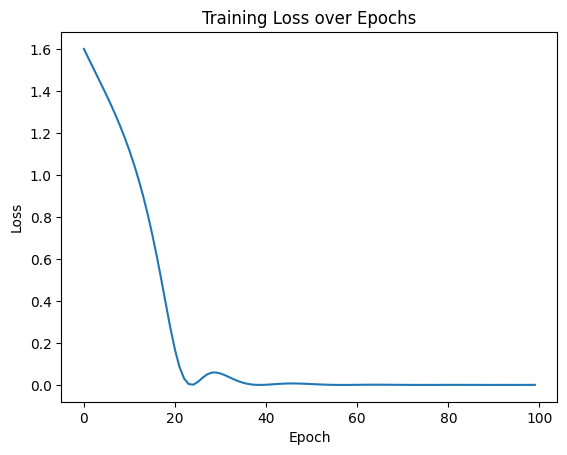

In [11]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [23]:
data_tensor

tensor([[[1.1211],
         [1.1214],
         [1.1212],
         ...,
         [0.0125],
         [0.0125],
         [0.0125]]], device='cuda:0')

In [12]:
# Save the trained model to local device
torch.save(model.state_dict(), './TrainedModals/lstm_model_2024-100ep.pth')

### Evaulate saved modal

In [18]:
from torchsummary import summary  # For model summary

model.load_state_dict(torch.load("./TrainedModals/lstm_model_2024-100ep.pth"))  # Adjust filename as needed

# Inspect model architecture
print("Model architecture:")
print(model)

# Move the model to CPU if it was trained on GPU
model.to('cpu')

# Perform inference
with torch.no_grad():
    output = model(data_tensor.unsqueeze(0))  # Add batch dimension if necessary
    predicted_close = output.item()  # Assuming output size is 1

# Print the predicted close price
print("Predicted close price:", predicted_close)

Model architecture:
LSTM(
  (lstm): LSTM(1, 32, num_layers=5, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead